# Fuzzy Logic Based Intelligent Braking System

##Introduction
This project demonstrates a Fuzzy Logic Controller (FLC) that determines the brake power required by a vehicle based on its speed and distance from an obstacle. The system simulates intelligent braking behavior

## Fuzzy Variables
Three fuzzy variables are used in this system:
1. Distance (input): Defines how close or far the vehicle is from an obstacle.
2. Speed (input): Represents the velocity of the vehicle.
3. Brake Power (output): The percentage of braking force applied.

 ## Memebership Functions

Triangular membership functions represent linguistic terms like Near, Medium, and Far for distance, and Low, Medium, High for speed and brake power. These allow smooth transitions between states.


 ## Rule Base
  The system uses human-like IF–THEN rules for inference. For example:
  1. IF distance is Far AND speed is Low THEN Brake Power is Low
  2. IF distance is Medium AND speed is Medium THEN Brake Power is Medium
  3. IF distance is Near AND speed is High THEN Brake Power is High
  4. IF distance is Near AND speed is Low THEN Brake Power is Medium
   

In [9]:
pip install numpy matplotlib scikit-fuzzy

In [10]:
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import matplotlib.pyplot as plt

#Defining fuzzy variables
distance = ctrl.Antecedent(np.arange(0, 21, 1), 'distance')#m
speed = ctrl.Antecedent(np.arange(0, 101, 1), 'speed')#km/h
brake_power = ctrl.Consequent(np.arange(0, 101, 1), 'brake_power')#%

#Defining Membership Functions
distance['close'] = fuzz.trimf(distance.universe, [0, 5, 10])
distance['medium'] = fuzz.trimf(distance.universe, [5, 10, 15])
distance['far'] = fuzz.trimf(distance.universe, [10, 20, 20])

speed['slow'] = fuzz.trimf(speed.universe, [0, 15, 30])
speed['normal'] = fuzz.trimf(speed.universe, [20, 50, 80])
speed['fast'] = fuzz.trimf(speed.universe, [60, 100, 100])

brake_power['none'] = fuzz.trimf(brake_power.universe, [0, 0, 20])
brake_power['light'] = fuzz.trimf(brake_power.universe, [10, 30, 50])
brake_power['moderate'] = fuzz.trimf(brake_power.universe, [40, 60, 80])
brake_power['hard'] = fuzz.trimf(brake_power.universe, [70, 90, 100])

#Defining Fuzzy Rule
rule1 = ctrl.Rule(distance['far'] & speed['slow'], brake_power['none'])
rule2 = ctrl.Rule(distance['medium'] & speed['normal'], brake_power['light'])
rule3 = ctrl.Rule(distance['close'] & speed['slow'], brake_power['moderate'])
rule4 = ctrl.Rule(distance['close'] & speed['fast'], brake_power['hard'])
rule5 = ctrl.Rule(distance['medium'] & speed['fast'], brake_power['moderate'])
rule6 = ctrl.Rule(distance['far'] & speed['fast'], brake_power['light'])

#4.Creating Control System and Simulation
braking_ctrl = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5, rule6])
braking_sim = ctrl.ControlSystemSimulation(braking_ctrl)



Lets now plot the graphs

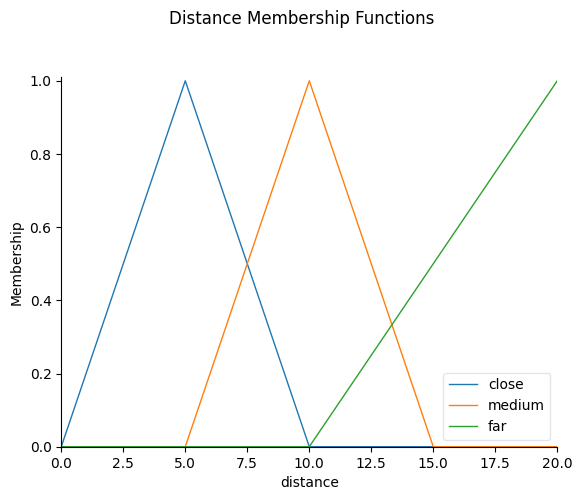

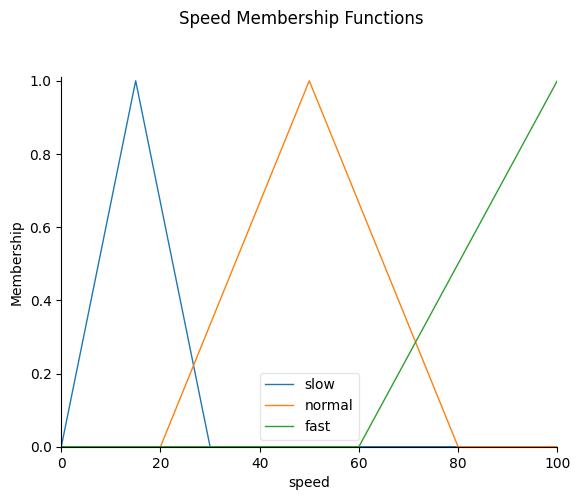

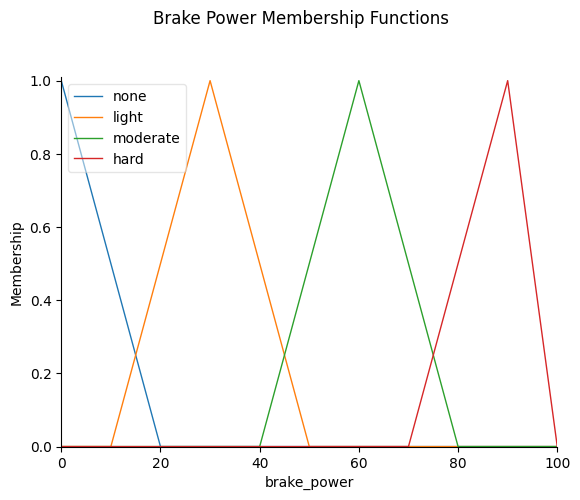

In [11]:
#distance membership functions
distance_fig = distance.view()
plt.gcf().suptitle('Distance Membership Functions', y=1.02)
plt.show()
#speed membership functions
speed_fig = speed.view()
plt.gcf().suptitle('Speed Membership Functions', y=1.02)
plt.show()
#brake power membership functions
brake_fig = brake_power.view()
plt.gcf().suptitle('Brake Power Membership Functions', y=1.02)
plt.show()

Membership Function Graphs: Show how fuzzy sets define 'near', 'medium', 'far', etc.

## Simulation
During the simulation, the vehicle starts at a given speed and distance. At each time step, the fuzzy controller calculates the necessary brake power. As the vehicle approaches the obstacle, brake power increases, reducing the speed gradually.

Lets now create the real time simulation loop

Fuzzy Braking System Simulation Start 
Time (s)   | Dist (m)   | Speed (km/h)    | Brake Power (%)
-------------------------------------------------------
0.0        | 18.00      | 75.00           | 30.00          
0.1        | 15.92      | 74.60           | 30.00          
0.2        | 13.84      | 74.20           | 42.18          
0.3        | 11.78      | 73.56           | 48.04          
0.4        | 9.74       | 72.80           | 49.28          
0.5        | 7.72       | 72.01           | 56.74          
0.6        | 5.72       | 71.08           | 61.51          
0.7        | 3.74       | 70.05           | 85.60          
0.8        | 1.80       | 68.53           | 85.51          
-------------------------------------------------------
Simulation complete.
Number of data points collected: 9


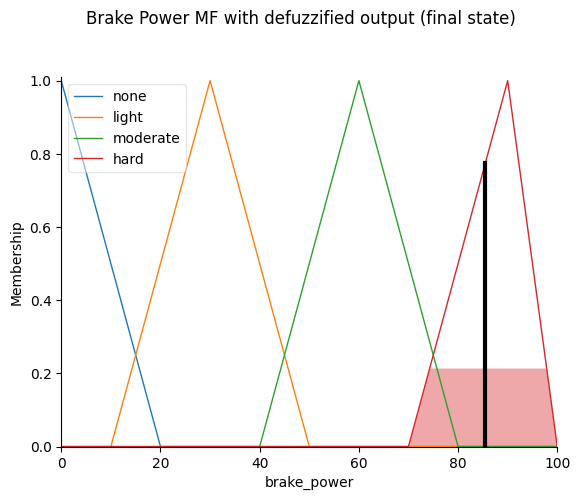

In [12]:
#Simulation Parameters
current_distance = 18.0#m
current_speed = 75.0#km/h
time_step = 0.1#s
velocity_change = 0.2#km/h per step
time = 0.0
results = []

print("Fuzzy Braking System Simulation Start ")
print(f"{'Time (s)':<10} | {'Dist (m)':<10} | {'Speed (km/h)':<15} | {'Brake Power (%)':<15}")
print("-" * 55)

#Simulation Loop
while current_distance > 1.0 and time < 20:
    braking_sim.input['distance'] = current_distance
    braking_sim.input['speed'] = current_speed
    braking_sim.compute()
    braking_power_output = braking_sim.output['brake_power']
    results.append({
        'time': time,
        'distance': current_distance,
        'speed': current_speed,
        'brake_power': braking_power_output
    })

    print(f"{time:<10.1f} | {current_distance:<10.2f} | {current_speed:<15.2f} | {braking_power_output:<15.2f}")

    # deceleration which is proportional to brake_power
    deceleration = (braking_power_output / 100.0) * 20.0  # km/h per second

    # speed updation
    new_speed = current_speed + velocity_change - (deceleration * time_step)

    # distance updation
    speed_mps = current_speed * (1000 / 3600)
    current_distance -= speed_mps * time_step

    #clamp values
    current_speed = max(0.0, new_speed)
    current_distance = max(0.01, current_distance)

    time += time_step

print("-" * 55)
print("Simulation complete.")
print(f"Number of data points collected: {len(results)}")

#brake_power membership function with current simulation state
if results:
    last = results[-1]
    braking_sim.input['distance'] = last['distance']
    braking_sim.input['speed'] = last['speed']
    braking_sim.compute()
    #defuzzified output
    brake_power.view(sim=braking_sim)
    plt.gcf().suptitle('Brake Power MF with defuzzified output (final state)', y=1.02)
    plt.show()



This above is the brake power membership graph with a vertical line and shaded region marking the final crisp value.

That point represents the actual brake power calculated by the fuzzy logic system after combining all fuzzy rules

Lets now plot the time series results

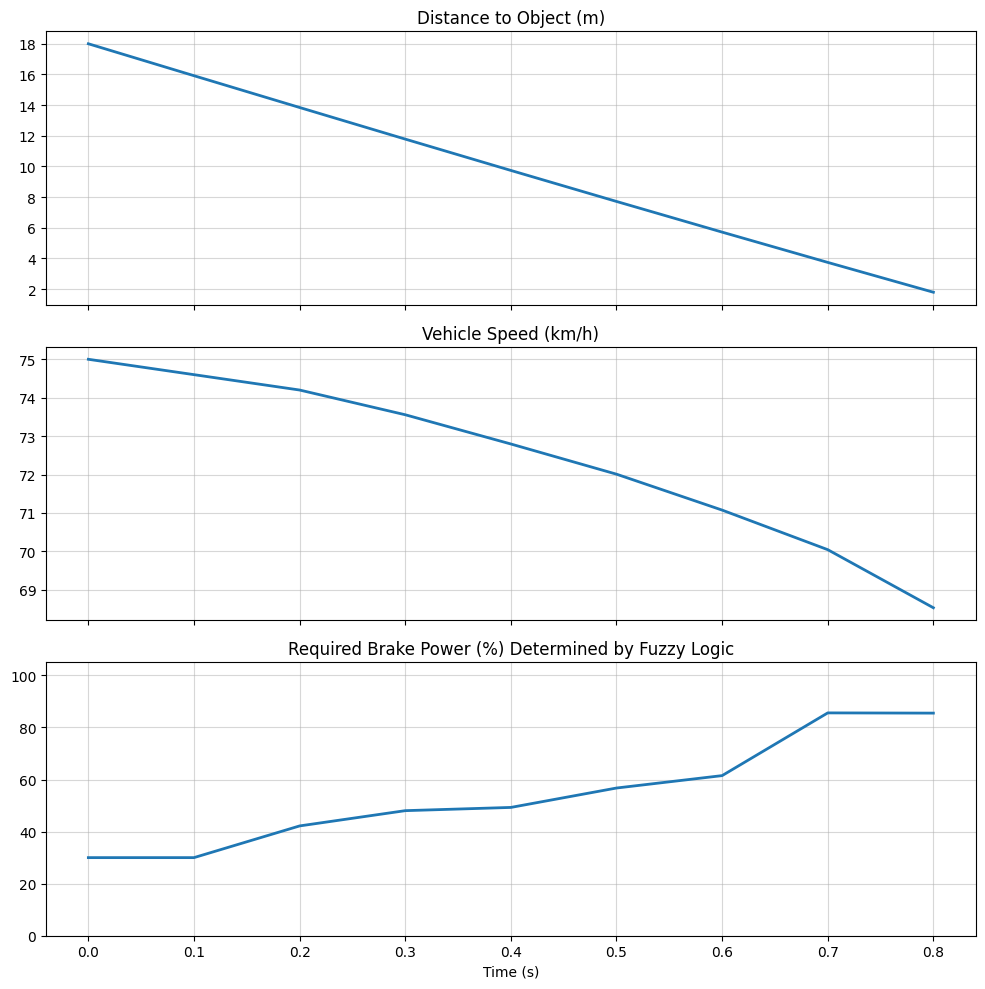

In [13]:
if not results:
    print("No data collected for plotting.")
else:
    times = np.array([r['time'] for r in results])
    distances = np.array([r['distance'] for r in results])
    speeds = np.array([r['speed'] for r in results])
    brake_powers = np.array([r['brake_power'] for r in results])

    fig, ax = plt.subplots(3, 1, figsize=(10, 10), sharex=True)

    ax[0].plot(times, distances, linewidth=2)
    ax[0].set_title('Distance to Object (m)')
    ax[0].grid(True, alpha=0.5)

    ax[1].plot(times, speeds, linewidth=2)
    ax[1].set_title('Vehicle Speed (km/h)')
    ax[1].grid(True, alpha=0.5)

    ax[2].plot(times, brake_powers, linewidth=2)
    ax[2].set_title('Required Brake Power (%) Determined by Fuzzy Logic')
    ax[2].set_xlabel('Time (s)')
    ax[2].grid(True, alpha=0.5)
    ax[2].set_ylim(0, 105)

    plt.tight_layout()
    plt.show()

Distance vs Time: Distance decreases as the vehicle moves toward the obstacle.

The blue line decreases from ~18 m to ~1 m over time.

It shows that as braking increases, the vehicle approaches the obstacle in a controlled, non-abrupt way.
_______________________________________________________________________


Speed vs Time: Speed reduces smoothly as braking increases.

The blue line shows a steady decrease in speed from ~75 km/h to ~68 km/h

Demonstrates how fuzzy logic ensures comfort and stability during braking.
___________________________________________________________________




Brake Power vs Time: Shows the fuzzy controller’s decision on braking intensity over time.

The blue line starts around 30%, then rises sharply to ~85% as time progresses.

This dynamic rise proves that the fuzzy controller intelligently adapts brake force in real time.